# Example of Implementing JATIC Protocol with Augly

This notebook demonstrates how to implement a pipeline for Augly that adheres to the protocol for `jatic_toolbox.protocol.Augmentations`.
The examples in this notebook are taken from: https://github.com/facebookresearch/AugLy/blob/main/examples/AugLy_image.ipynb.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
import os
import random
from io import BytesIO

import augly.image as imaugs
from augly import utils
import numpy as np
import requests
from PIL import Image

from jatic_toolbox.protocols import Augmentation
from jatic_toolbox.interop.augly import Augly


## Load Example Image

(-0.5, 959.5, 539.5, -0.5)

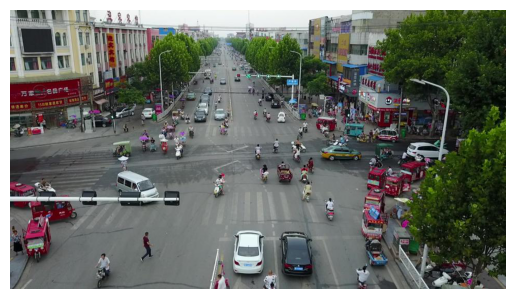

In [3]:
url = "https://data.kitware.com/api/v1/item/623880f14acac99f429fe3ca/download"
response = requests.get(url)
img_pil = Image.open(BytesIO(response.content))
img = np.asarray(img_pil)

plt.figure()
plt.imshow(img)
plt.axis("off")

## Create Augly Pipeline

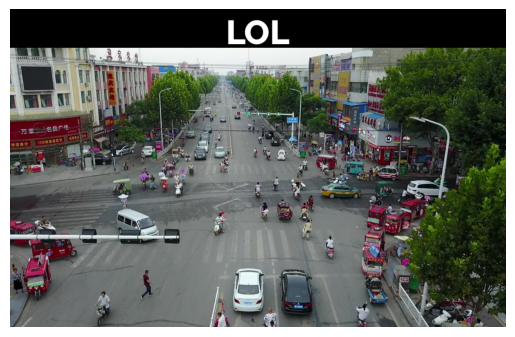

In [4]:
# imaugs.meme_format(
#         img_pil,
#         caption_height=75,
#         meme_bg_color=(0, 0, 0),
#         text_color=(255, 255, 255),
#     )

xform = Augly(
    imaugs.meme_format,
    caption_height=75,
    meme_bg_color=(0, 0, 0),
    text_color=(255, 255, 255),
)
out = xform(img_pil)

ax = plt.subplots()[1]
ax.imshow(out)
ax.set_axis_off()


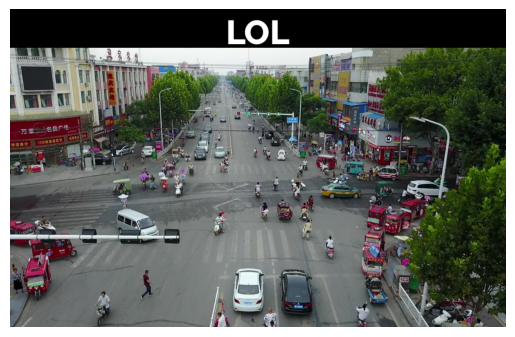

In [5]:
xform = Augly(
    imaugs.meme_format,
    caption_height=75,
    meme_bg_color=(0, 0, 0),
    text_color=(255, 255, 255),
)
out = xform(np.asarray(img_pil))


ax = plt.subplots()[1]
ax.imshow(out)
ax.set_axis_off()


[{'name': 'saturation',
  'src_width': 960,
  'src_height': 540,
  'dst_width': 960,
  'dst_height': 540,
  'output_path': None,
  'factor': 2.0,
  'bbox_format': None,
  'intensity': 20.0},
 {'name': 'overlay_onto_screenshot',
  'src_width': 960,
  'src_height': 540,
  'dst_width': 414,
  'dst_height': 736,
  'output_path': None,
  'template_filepath': '/home/justin_goodwin/.conda/envs/raise/lib/python3.10/site-packages/augly/assets/screenshot_templates/mobile.png',
  'template_bboxes_filepath': '/home/justin_goodwin/.conda/envs/raise/lib/python3.10/site-packages/augly/assets/screenshot_templates/bboxes.json',
  'max_image_size_pixels': None,
  'crop_src_to_fit': False,
  'resize_src_to_match_template': True,
  'bbox_format': None,
  'intensity': 66.9725372820836},
 {'name': 'scale',
  'src_width': 414,
  'src_height': 736,
  'dst_width': 248,
  'dst_height': 441,
  'output_path': None,
  'factor': 0.6,
  'interpolation': None,
  'bbox_format': None,
  'intensity': 16.666666666666668}

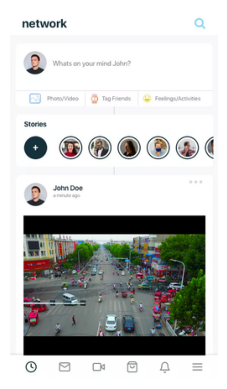

In [6]:
# You can also compose several transformations together
meta = []
aug = imaugs.Compose(
    [
        imaugs.Saturation(factor=2.0),
        imaugs.OverlayOntoScreenshot(
            template_filepath=os.path.join(
                utils.SCREENSHOT_TEMPLATES_DIR, "mobile.png"
            ),
        ),
        imaugs.Scale(factor=0.6),
    ]
)

xform = Augly(aug, metadata=meta)
out = xform(dict(image=img_pil))

ax = plt.subplots()[1]
ax.imshow(out["image"])
ax.set_axis_off()
meta


Text(0.5, 1.0, 'Dict Input')

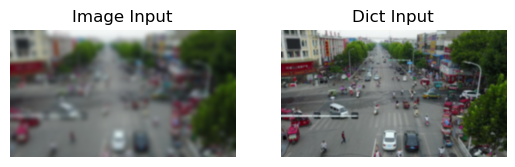

In [7]:
# meta = []
# aug = imaugs.RandomAspectRatio()
# display(aug(input_img, metadata=meta))
# meta

xform = Augly(imaugs.RandomBlur())
out = xform(img_pil, dict(image=img_pil), rng=1)
out2 = xform(img_pil, dict(image=img_pil), rng=1)
out3 = xform(img_pil, dict(image=img_pil), rng=2)
out4 = xform(img_pil, dict(image=img_pil), rng=random.Random(1))
assert isinstance(out, tuple)
assert isinstance(out2, tuple)
assert isinstance(out3, tuple)
assert isinstance(out4, tuple)
assert np.all(out[0]==out2[0])
assert np.all(out[0]!=out3[0])
assert np.all(out[0]==out4[0])

ax = plt.subplots(ncols=2)[1]
ax[0].imshow(out[0])
ax[0].set_axis_off()
ax[0].set_title("Image Input")

ax[1].imshow(out[1]["image"])
ax[1].set_axis_off()
ax[1].set_title("Dict Input")


[{'name': 'crop',
  'src_width': 960,
  'src_height': 540,
  'dst_width': 624,
  'dst_height': 270,
  'output_path': None,
  'x1': 0.1,
  'y1': 0.25,
  'x2': 0.75,
  'y2': 0.75,
  'bbox_format': 'pascal_voc',
  'src_bboxes': [(25, 50, 75, 80)],
  'dst_bboxes': [(25, 50, 75, 80)],
  'intensity': 67.5}]

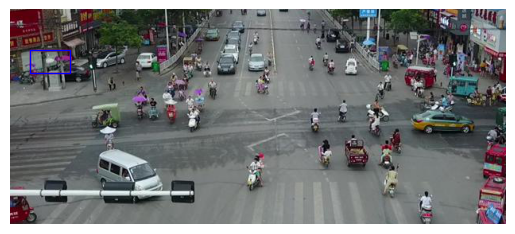

In [8]:
# meta = []
# aug_image = imaugs.crop(
#     image_path,
#     bboxes=[(0.25, 0.5, 0.75, 0.8)],
#     bbox_format="pascal_voc_norm",
#     metadata=meta,
# )


def show_bbox(ax, bboxes, edgecolor: str = "r"):
    from matplotlib.patches import Rectangle

    for bbox in bboxes:
        x1, y1, x2, y2 = bbox
        ax.add_patch(
            Rectangle(
                (x1, y1),
                x2 - x1,
                y2 - y1,
                linewidth=1,
                edgecolor=edgecolor,
                facecolor="none",
            )
        )


meta = []
xform = Augly(
    imaugs.crop,
    x1=0.1,
    bboxes=[(25, 50, 75, 80)],
    bbox_format="pascal_voc",
    metadata=meta,
)
out = xform(img_pil)

ax = plt.subplots()[1]
ax.imshow(out)
show_bbox(ax, meta[0]["src_bboxes"])
show_bbox(ax, meta[0]["dst_bboxes"], edgecolor="b")
ax.set_axis_off()
meta
